# Tyre quality classification project comparing resnet architectures 

This code initializes the working environment by importing necessary libraries for deep learning (fastai), numerical operations (numpy), data visualization (matplotlib), and performance metrics (roc_curve, auc from sklearn).

The set_seed function ensures reproducibility, crucial for consistent results across different runs.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import time
import matplotlib.pyplot as plt
from fastai.vision.all import *
import torch
import numpy as np
import random
from sklearn.metrics import roc_curve, auc

# Seed function to set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
set_seed(42)


The dataset is prepared using fastai's DataBlock API. 

This process includes defining how to **load images** (ImageBlock), how to categorize them (CategoryBlock), and how to split them into **training and validation sets*** (RandomSplitter). 

**Image transformations**, such as resizing and normalization, are applied to make the model training more consistent and effective. 

**Data augmentation techniques** (random flips, rotations) are used to increase the robustness of the model against real-world data variations.

Number of training examples: 1485, Number of validation examples: 371


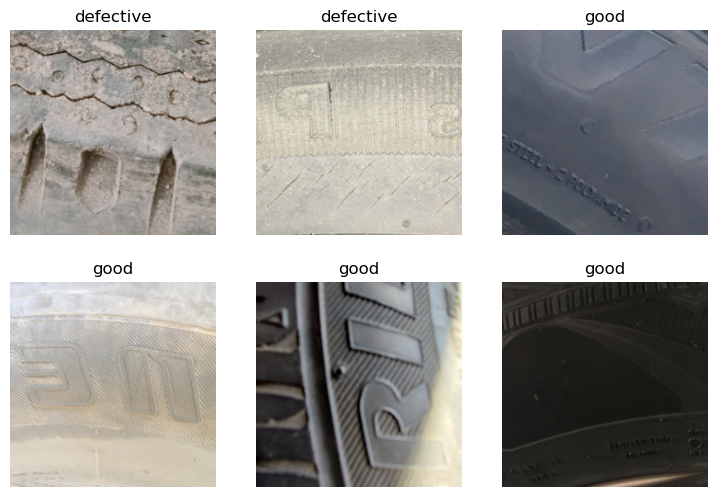

In [7]:
# Data loaders setup
path = Path('D:\projects\Digital images of defective and good condition tyres')
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
)
print(data)
dls = data.dataloaders(path)
print(dls)

# Data exploration and visualization
dls.show_batch(max_n=6)
print(f"Number of training examples: {len(dls.train_ds)}, Number of validation examples: {len(dls.valid_ds)}")


# Model Training and Evaluation

This section defines the key metrics used for evaluating the model's performance. The chosen metrics are accuracy and ROC-AUC (Receiver Operating Characteristic - Area Under Curve). Accuracy measures the proportion of correct predictions, while ROC-AUC provides insights into the model's ability to distinguish between the two classes (defective and good condition tyres).

Additionally, a function to plot the ROC curve is implemented. The ROC curve is crucial in binary classification tasks, as it illustrates the model's capability to discriminate between classes at various threshold settings. The area under the curve (AUC) represents the model's effectiveness, with higher values indicating better performance.


In [8]:
metrics = [accuracy, RocAucBinary()]

# Function to plot ROC Curve
def plot_roc_curve(learn, title="ROC Curve"):
    preds, targets = learn.get_preds()
    fpr, tpr, thresholds = roc_curve(targets, preds[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

## Training ResNet34 and Measuring Training Time

The ResNet34 model, a popular convolutional neural network architecture, is trained using FastAI's `vision_learner`. The learning rate is optimized using the `lr_find` method. This method identifies an optimal learning rate by increasing the rate exponentially and plotting the loss, helping avoid underfitting or overfitting due to a poorly chosen rate.


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\G3 CTIN/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:23<00:00, 3.79MB/s]


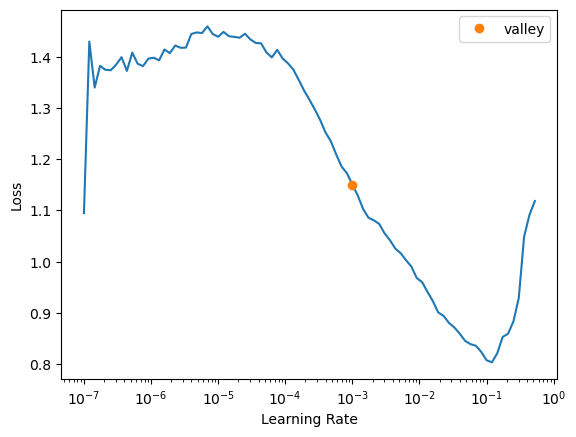

In [9]:
learn_resnet34 = vision_learner(dls, resnet34, metrics=metrics)
lr_resnet34 = learn_resnet34.lr_find()

Using suggested learning rate the model is fine-tuned for 10 epochs. Fine-tuning involves adjusting the weights of a pre-trained model (here, ResNet34) to better suit our specific task. We use early stopping, a form of regularization used to avoid overfitting by halting the training process if the model's performance on the validation set doesn't improve after a specified number of epochs (`patience=3` in this case). This approach ensures efficient and effective learning. Additionally, we record the training time to assess the model's training efficiency.

In [10]:
start_time_resnet34 = time.time()

learn_resnet34.fine_tune(10, base_lr=lr_resnet34.valley, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

end_time_resnet34 = time.time()
training_time_resnet34 = end_time_resnet34 - start_time_resnet34
training_time_resnet34

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.809189,0.277730,0.894879,0.960703,07:51


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.374174,0.214701,0.916442,0.974355,11:05
1,0.333934,0.164636,0.935310,0.985300,09:36
2,0.254785,0.128245,0.948787,0.991326,09:27
3,0.191244,0.126920,0.956873,0.992082,09:53
4,0.144855,0.142135,0.940701,0.992403,08:47
5,0.109874,0.123753,0.956873,0.994236,08:19
6,0.080618,0.123592,0.959569,0.994120,08:24
7,0.056501,0.117953,0.962264,0.994877,08:31
8,0.040544,0.112294,0.959569,0.995081,09:31
9,0.033543,0.112515,0.964960,0.995139,08:41


6014.50728225708

After training, the model's performance is evaluated against the validation dataset. This step is crucial to understand how well the model generalizes to new, unseen data.

In [11]:
# Evaluate ResNet34 and get accuracy
accuracy_resnet34 = learn_resnet34.validate()[1]
accuracy_resnet34

0.9649595618247986

We use FastAI's `ClassificationInterpretation` to visualize the top losses and construct a confusion matrix for the ResNet34 model. These visualizations help in understanding the kinds of errors the model is making, which is crucial for further refinement.

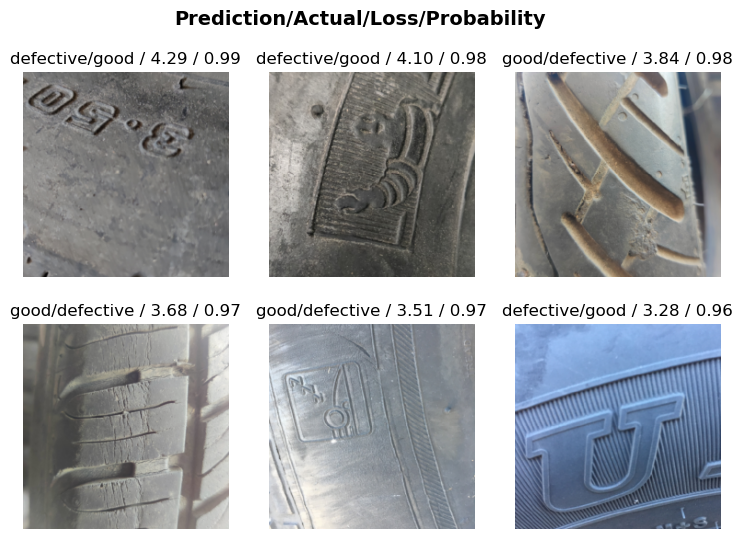

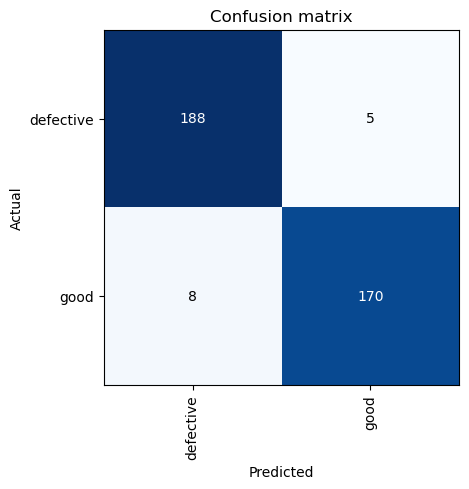

In [12]:
# Visualization for ResNet34
interp_resnet34 = ClassificationInterpretation.from_learner(learn_resnet34)
interp_resnet34.plot_top_losses(k=6)
interp_resnet34.plot_confusion_matrix()
plt.show()

To further assess the model's discriminative ability, we plot the ROC curve. This visualization helps in understanding the trade-off between the true positive rate and false positive rate at various threshold settings.

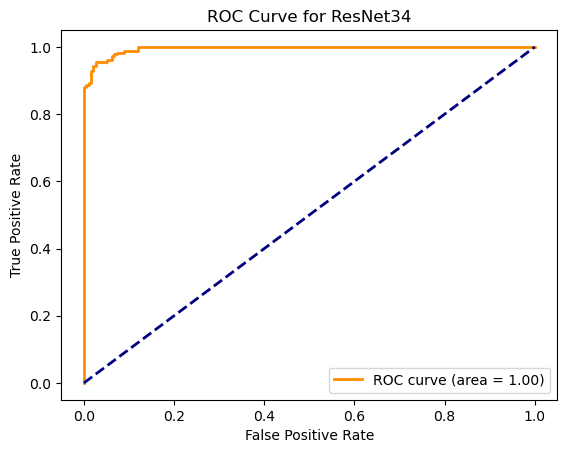

In [13]:
# Plot ROC Curve for ResNet34
plot_roc_curve(learn_resnet34, "ROC Curve for ResNet34")

The area under the curve (AUC) is a measure of the model's ability to discriminate between positive and negative classes. The AUC value is 0.99, which is very close to the perfect score of 1. This suggests that the ResNet34 model has an excellent performance on the dataset, with a high true positive rate and a low false positive rate, indicating a high level of accuracy in distinguishing between defective and good condition tyres.

## ResNet50

Similar to ResNet34, we use the `vision_learner` to instantiate the ResNet50 model. The learning rate is optimized using `lr_find` to start the training process under optimal conditions.


In [ ]:
# Train ResNet50
learn_resnet50 = vision_learner(dls, resnet50, metrics=metrics)
lr_resnet50 = learn_resnet50.lr_find()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\G3 CTIN/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:27<00:00, 3.80MB/s]


The ResNet50 model is fine-tuned for 10 epochs with early stopping. Given that ResNet50 is deeper than ResNet34, it might capture more complex patterns in the data, but is also more prone to overfitting, making early stopping crucial. Training time is recorded for comparison with ResNet34.


In [ ]:
start_time_resnet50 = time.time()

learn_resnet50.fine_tune(10, base_lr=lr_resnet50.valley, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

end_time_resnet50 = time.time()
training_time_resnet50 = end_time_resnet50 - start_time_resnet50
training_time_resnet50

We evaluate the ResNet50 model's performance on the validation dataset and visualize the top losses and confusion matrix, similar to what we did for ResNet34. This step is critical to compare the performance and error characteristics of the two models.


In [ ]:
# Evaluate ResNet50 and get accuracy
accuracy_resnet50 = learn_resnet50.validate()[1]
accuracy_resnet50

The evaluation of the ResNet50 model follows a similar process as with ResNet34. We assess its performance on the validation dataset and use `ClassificationInterpretation` to visualize top losses and the confusion matrix. These steps are vital to understand how ResNet50 compares to ResNet34 in terms of performance and error characteristics. Additionally, the ROC curve for ResNet50 is plotted to further assess its discriminative ability.

In [ ]:
# Visualization for ResNet50
interp_resnet50 = ClassificationInterpretation.from_learner(learn_resnet50)
interp_resnet50.plot_top_losses(k=6)
interp_resnet50.plot_confusion_matrix()
plt.show()

In [ ]:
# Plot ROC Curve for ResNet50
plot_roc_curve(learn_resnet50, "ROC Curve for ResNet50")

# Comparison

To objectively compare the performance of ResNet34 and ResNet50, we print the training times and accuracies. This comparison helps us to understand the trade-offs between model complexity and performance, guiding our decision on which model is more suitable for the task at hand.


In [ ]:
# Print training times and accuracies
print(f"Training time for ResNet34: {training_time_resnet34:.2f} seconds")
print(f"Accuracy for ResNet34: {accuracy_resnet34:.4f}")
print(f"Training time for ResNet50: {training_time_resnet50:.2f} seconds")
print(f"Accuracy for ResNet50: {accuracy_resnet50:.4f}")

With early stopping, it took both models simillar learning times but the difference between accuracy is substantial. That means the **ResNet50** is better as expected - it is more complex and bigger model and in this case it was worth using it!

## Exporting

Once training is complete, we export the models as `.pkl` files. This step ensures that we can easily reload and use our trained models in the future without the need to retrain them. This is especially useful for deploying the models in a production environment or for further analysis.


In [ ]:
learn_resnet34.export('resnet34_model.pkl')
learn_resnet50.export('resnet50_model.pkl')

# Interactive Inference

To demonstrate the practical application of our trained model, we create an interactive tool for tire quality prediction. Using FastAI's functionality, we load our trained model and set up a file upload widget. Users can upload images of tyres, and the model will predict their quality. The interactive nature of this tool makes it user-friendly and suitable for non-technical stakeholders to assess the model's performance in real-world scenarios.

In [16]:
import time
import ipywidgets as widgets
from IPython.display import display
from fastai.vision.all import PILImage, load_learner
from PIL import UnidentifiedImageError

# Models
models = {'ResNet34': 'resnet34_model.pkl', 'ResNet50': 'resnet50_model.pkl'}

# Load selected model
def load_model(change):
    global learn
    learn = load_learner(models[change.new])

# Widget holder
vbox = widgets.VBox()

# Title and description
title = widgets.HTML('<h1>Tyre Defect Classifier</h1>')
description = widgets.HTML('<p>This tool classifies tyres as defective or good.</p>')
vbox.children += (title, description,)

# Dropdown for model selection
model_selector = widgets.Dropdown(options=models.keys(), description='Model:')
model_selector.observe(load_model, names='value')
vbox.children += (model_selector,)

# Load the initial model
learn = load_learner(models[model_selector.value])

# File upload widget
uploader = widgets.FileUpload()
vbox.children += (widgets.Label('Upload your image:'), uploader,)

# Button for predictions
predict_btn = widgets.Button(description="Predict", disabled=True, button_style='success')
vbox.children += (predict_btn,)

# Output widgets, showing image and label
output_image = widgets.Output()
output_label = widgets.Label()
vbox.children += (output_image, output_label,)

# Change states of the button
def update_button_state(change):
    predict_btn.disabled = not bool(uploader.data)

uploader.observe(update_button_state, names='data')

# Define the prediction function
def on_click_classify(change):
    output_image.clear_output()
    output_label.value = ''
    if uploader.data:
        try:
            img = PILImage.create(uploader.data[-1])
            with output_image:
                display(img.to_thumb(128, 128))
            start_time = time.time()
            pred, _, probs = learn.predict(img)
            end_time = time.time()
            output_label.value = f'Prediction: {pred}; Probability: {max(probs):.04f}; Time taken: {end_time - start_time:.2f} seconds'
        except UnidentifiedImageError:
            output_label.value = 'Error: Uploaded file is not a valid image. Please upload a valid image file.'
        except Exception as e:
            output_label.value = f'Error: {str(e)}'
        
        # Clear the uploader's data
        uploader.value.clear()
        uploader._counter = 0
        predict_btn.disabled = True

# Attach the event handler to the predict button
predict_btn.on_click(on_click_classify)

# Display the VBox
display(vbox)
